### Provide dataset folder path below to run the notebook components

In [1]:
train_data_path = '/kaggle/input/gsoc24-deeplense-common-task/dataset/train'
test_data_path = '/kaggle/input/gsoc24-deeplense-common-task/dataset/val'
pretrained_model_path = '/kaggle/input/resnet34-pretrained/best_model_params_resnet_34.pt'
results_folder = '/kaggle/working/results' #only needed if training from scractch

Text(0.5, 1.0, 'vort')

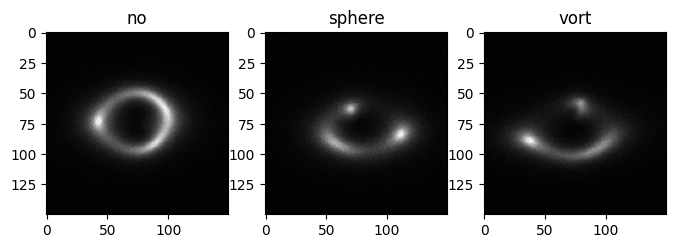

In [2]:
#Visualize substructures from all threee classes

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 

img_no = np.load('/kaggle/input/gsoc24-deeplense-common-task/dataset/train/no/10.npy')
img_sphere = np.load('/kaggle/input/gsoc24-deeplense-common-task/dataset/train/sphere/10.npy')
img_vort = np.load('/kaggle/input/gsoc24-deeplense-common-task/dataset/train/vort/1.npy')
fig, axs =  plt.subplots(1,3, figsize=(8,8))
axs[0].imshow(img_no[0,:,:], cmap='gray')
axs[0].set_title('no')
axs[1].imshow(img_sphere[0,:,:], cmap='gray')
axs[1].set_title('sphere')
axs[2].imshow(img_vort[0,:,:], cmap='gray')
axs[2].set_title('vort')
    

In [3]:
# code for exracting image paths from the provided folder and dividing them into train, val(90%) and test(10%)
import glob
import random
from pandas.core.common import flatten
import random

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

# get all the paths from train_data_path and append image paths and class to to respective lists
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))
random.shuffle(test_image_paths)

# create 90:10 split for validation and testing
val_image_paths, test_image_paths = test_image_paths[:int(0.9*len(test_image_paths))], test_image_paths[int(0.9*len(test_image_paths)):] 
print("Train size: {}\nValidation size: {}\nTest size: {}".format(len(train_image_paths), len(val_image_paths), len(test_image_paths)))

Train size: 30000
Validation size: 6750
Test size: 750


In [4]:
# to convert classes to indices and indices back to classes
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [5]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from multiprocessing import cpu_count


class Dataset(Dataset):
    def __init__(self, image_paths, stage='train'):
        self.image_paths = image_paths
        self.stage = stage
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        
        image = np.load(image_filepath)
        image = image.reshape(150 ,150)
        image = Image.fromarray(np.uint8((image)*255), 'L').convert('RGB')
        
        train_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
        ])
        val_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
        ])
        if self.stage == 'train':
            image = train_transform(image)
        else:
            image = val_transform(image)

        
        
        return image, label
    
train_dataset = Dataset(train_image_paths)
valid_dataset = Dataset(val_image_paths,stage='val') #test transforms are applied
test_dataset = Dataset(test_image_paths,stage='test')

In [6]:
#Create Dataloaders

train_loader = DataLoader(
    train_dataset, batch_size=256, shuffle=True, pin_memory = True, num_workers = cpu_count()
)
val_loader = DataLoader(
    valid_dataset, batch_size=256, shuffle=True, pin_memory = True, num_workers = cpu_count()
)
test_loader = DataLoader(
    test_dataset, batch_size=256, shuffle=False, pin_memory = True, num_workers = cpu_count()
)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from pathlib import Path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ft = models.resnet34(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)





### Only run the cell below if the model is to be trained from scratch

In [ ]:
results_folder = Path(results_folder)
results_folder.mkdir(exist_ok = True)

def train_model(model, criterion, optimizer, num_epochs=20):
    since = time.time()

    # Create a temporary directory to save training checkpoints
   
    best_model_params_path = os.path.join(results_folder, 'best_model_params_resnet34.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
                
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                epoch_loss = running_loss / len(train_dataset)
                epoch_acc = running_corrects.double() / len(train_dataset)
            else:
                epoch_loss = running_loss / len(valid_dataset)
                epoch_acc = running_corrects.double() / len(valid_dataset)

            

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Correct:{running_corrects}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
    return model

model_ft = train_model(model_ft, criterion, optimizer_ft,num_epochs=20)

### Run the cell below if pretrained model is to be loaded

In [8]:
model_ft.load_state_dict(torch.load(pretrained_model_path))

<All keys matched successfully>

### Below cell performs evaluation on the trained model and gives its accuracy, number of correct prediction and Average AUC for all classes.

In [9]:
running_corrects = 0
from torch import tensor
from torchmetrics.classification import MulticlassAUROC

y_pred = torch.empty(0, 3)
target = torch.empty(0, 3)

with torch.no_grad():
    for idx, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        if idx == 0:
            y_preds = model_ft(inputs)
            target = labels
        else:
            outputs = model_ft(inputs) 
            y_preds = torch.concat((y_preds, outputs), dim=0)
            target = torch.concat((target, labels), dim=0)

 
        if idx == 0:
            _, preds = torch.max(y_preds, 1)
        else:
            _, preds = torch.max(outputs, 1)

        running_corrects += torch.sum(preds == labels.data)
    
    metric = MulticlassAUROC(num_classes=3, average="macro", thresholds=None)
    auc = metric(y_preds, target)

    epoch_acc = running_corrects.double() / 750
    print(f'Test Acc: {epoch_acc:.4f} Correct:{running_corrects}/750 Average AUC Score:{auc}')


Test Acc: 0.9267 Correct:695/750 Average AUC Score:0.9852551817893982


### Below cell plots the RUC curve for every class individually (where class 0 = no, class 1 = sphere, class 2 = vort

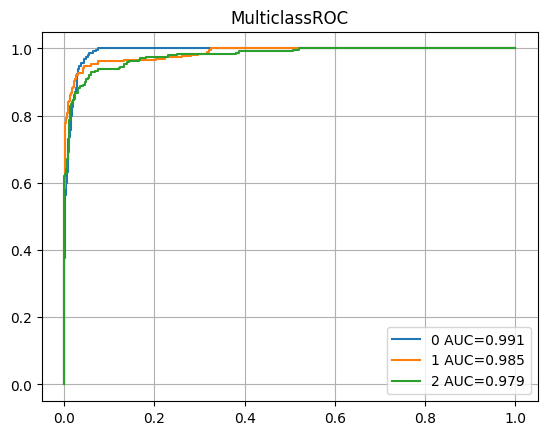

In [10]:
from torch import randn, randint
from torchmetrics.classification import MulticlassROC
metric = MulticlassROC(num_classes=3)
metric.update(y_preds, target)
fig_, ax_ = metric.plot(score=True)

### Below cell plots a single RUC curve by plotting the average RUC curve for all three classes

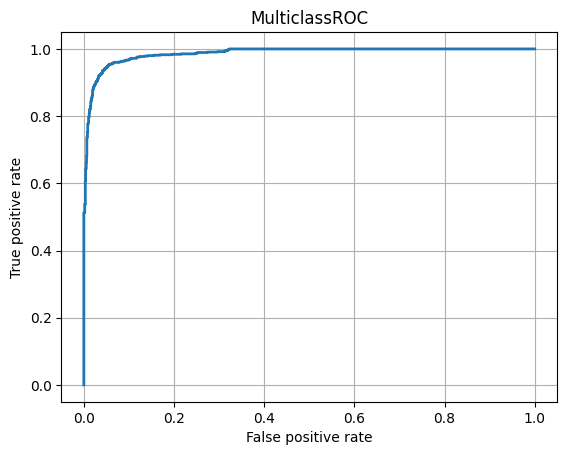

In [11]:
metric = MulticlassROC(num_classes=3, average='micro')
metric.update(y_preds, target)
fig_, ax_ = metric.plot()